In [93]:
import tensorflow as tf
from scipy.stats import boxcox
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, SimpleRNN, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.regularizers import l1, l2
import scipy.stats as ss# ss sirve para hacer la transformación de box-cox

Num GPUs Available:  1


In [94]:
df_dl=pd.read_csv('data.csv')
df_dl

,ID,PAY,ACCEPTED
0,786,27.352507,0
1,868,51.939040,1
2,846,24.451818,1
3,249,29.353959,1
4,434,20.568923,1
...,...,...,...
1295,579,25.306900,0
1296,871,36.827302,1
1297,209,20.824530,0
1298,165,26.291693,1


In [95]:
df_dl["ACCEPTED"].value_counts()

1    827
0    473
Name: ACCEPTED, dtype: int64

In [96]:
df_dl.isna().sum()

ID          0
PAY         0
ACCEPTED    0
dtype: int64

In [97]:
df_dl.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1300.0,497.563846,289.749383,1.0,249.000000,494.000000,744.000000,1000.000000
PAY,1300.0,26.626490,9.363111,0.0,20.801887,26.749334,33.348092,53.667563
ACCEPTED,1300.0,0.636154,0.481290,0.0,0.000000,1.000000,1.000000,1.000000


In [98]:
#conmsideramos puy a cero 
df_dl[df_dl["PAY"]==0]

,ID,PAY,ACCEPTED
215,781,0.0,0
365,701,0.0,0
373,478,0.0,0
376,63,0.0,0
859,987,0.0,0
999,177,0.0,0


In [99]:
df_renew=df_dl[df_dl['PAY'] > 0] # consideramos solo los valores mayores a cero


In [100]:
df_renew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1294 non-null   int64  
 1   PAY       1294 non-null   float64
 2   ACCEPTED  1294 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 40.4 KB


In [101]:
#agrupamos por ID para ver cuantos pagos se han hecho y cuantos se han aceptado
df_guay = df_renew.groupby('ID')[['PAY', 'ACCEPTED']].sum()

In [102]:
df_guay

,PAY,ACCEPTED
ID,,
1,29.358732,0
2,22.986847,0
3,18.020348,0
4,77.749694,2
5,14.642845,0
...,...,...
996,17.382310,0
997,20.855120,0
998,42.122166,1


C:\Users\victo\AppData\Local\Temp\ipykernel_12600\230468569.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ganancias, color='green', label='aceptadas')
C:\Users\victo\AppData\Local\Temp\ipykernel_12600\230468569.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perdidas, color='red', labe

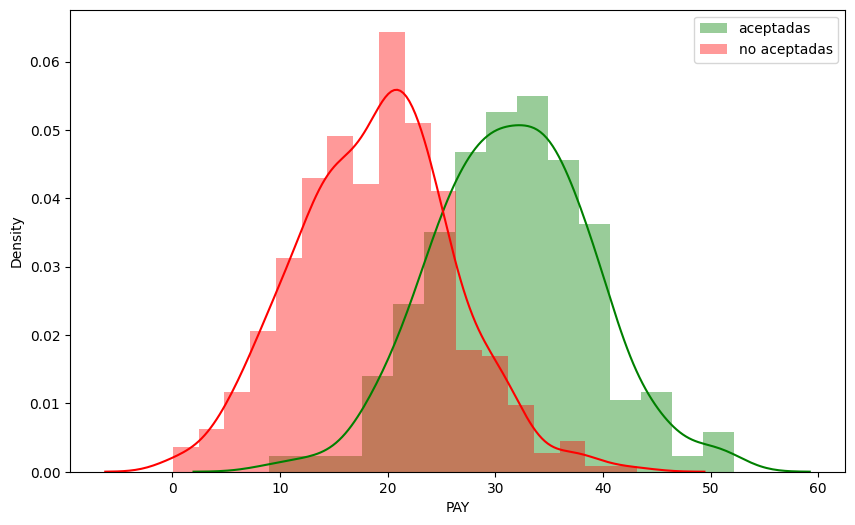

In [103]:
#visionamos  las aceptadas y no aceptadas del negocio
ganancias=df_guay.loc[df_guay['ACCEPTED'] == 1, 'PAY']#clientes q usan el servicio
perdidas=df_guay.loc[df_guay['ACCEPTED'] == 0, 'PAY']#clientes que no usan el servicio
plt.figure(figsize=(10,6))
sns.distplot(ganancias, color='green', label='aceptadas')
sns.distplot(perdidas, color='red', label='no aceptadas')
plt.legend();

las pagos aceptados y no acpetados siguen una distribucición gaussiana, siendo las lineas muy similares

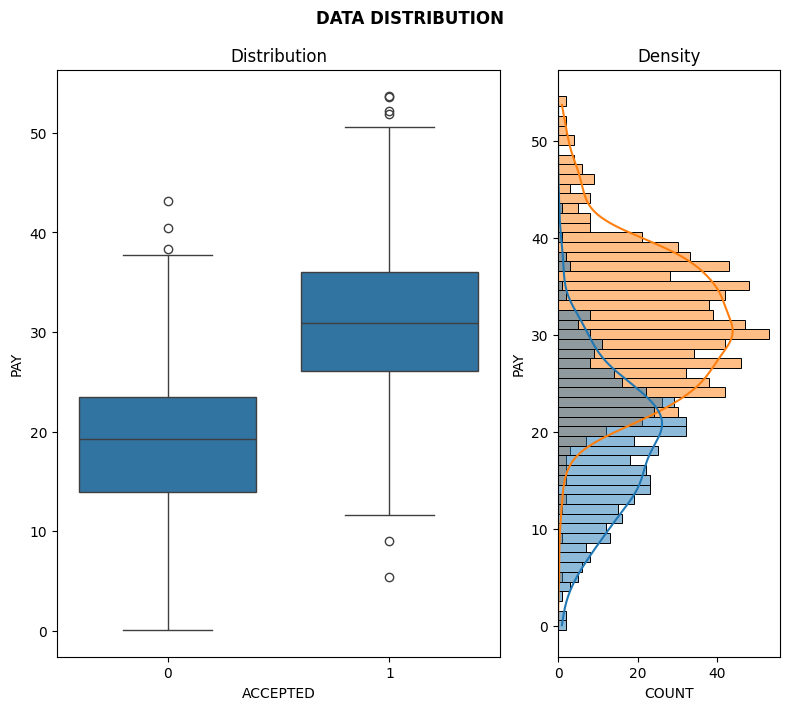

In [104]:
#visionamos la distribucion de los datos
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1.5]}, figsize=(8,7))
fig.suptitle('DATA DISTRIBUTION\n', fontweight='bold')
fig.tight_layout()

sns.boxplot(ax=ax[0], data=df_renew, x='ACCEPTED', y='PAY')
ax[0].set_title('Distribution')

sns.histplot(ax=ax[1], data=df_renew, y='PAY', hue='ACCEPTED', kde=True, discrete=True)
ax[1].set_title('Density')
ax[1].legend_.remove()
ax[1].set_xlabel('COUNT')

plt.show()

POSSION

In [105]:
def pmf_cdf(k:int, mu:int):
    '''
   Esta funcion nos permite visualizar la funcion de distribucion acumulada de la distribucion de poisson
    Args
        k: numero de pasos esperados
        mu: es el promedio de los pasos
    '''
    k = np.arange(k+1)# sirve para generar un rango de valores
    cdf = ss.poisson.cdf(k, mu)# sirve para generar la funcion de distribucion acumulada
    pmf = ss.poisson.pmf(k, mu)# sirve para generar la masa de probabilidad
    plt.plot(k, cdf, marker='o')
    plt.plot(k, pmf, marker='o')
    plt.xlabel('k')
    plt.ylabel('Probabilidad acumulada')
    plt.ylabel('masa de probabilidad acumulada')
    plt.title('Funcion de distribucion acumulada')
    plt.show()

In [106]:
max_accept = df_guay['ACCEPTED'].max()
print(f'Maximo de aceptados: {max_accept}')

Maximo de aceptados: 5


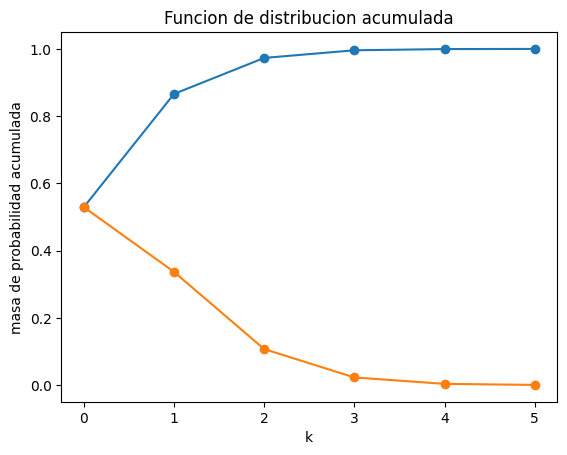

In [107]:
pmf_cdf(max_accept, df_dl['ACCEPTED'].mean())

In [108]:
#calculamos la ganacia de un mes
mes=30
beneficios=df_renew['PAY'].sum() - (len(df_renew)*mes)
print(f'beneficios de un mes: {beneficios} ')



beneficios de un mes: -4205.562633264068 


In [109]:
#las adquisiciones de los clientes en ratio
ratio = df_guay.drop_duplicates().sum()["ACCEPTED"] / len(df_guay)*100
print(f'Ratio de adquisiciones: {ratio}')

Ratio de adquisiciones: 83.19919517102615


# primer modelo 

In [110]:
#  la columna que contiene tu serie temporal los ingresos dentro de 12 meses
df = df_renew[['PAY']]

#escalo datos para que esten entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [111]:
# Crea nuevas características de desfase con desplazamientos de 1 a 12 meses, 
# elimna las filas con NaN que se vajan creando con los desfases
look_back = 12#numero de meses
df = pd.DataFrame(df)#creo un dataframe vacio
for i in range(1, look_back+1):
    df['desfase_' + str(i)] = df[0].shift(i)#las nuevas columnas se llamaran desfase_1,
                                            #desfase_2, desfase_3, etc donde se iran desplazando los datos

# Elimina las filas con NaN (que se crearon al desfasar los datos)
df = df.dropna()

In [112]:
# Convierte el DataFrame a un array de numpy
data = df.values
data = data.astype('float32')

In [113]:
# Creamos X e y con el paso de tiempo de 1 con la funcion
def create_dataset(df, look_back=1):
    X, y = [], []
    for i in range(len(df)-look_back-1):
        a = df[i:(i+look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [114]:
# Crea X e y
X, y = create_dataset(data, look_back)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Redimensiona los datos para que tengan la para serie temporal simulando p, q, d [muestras, pasos de tiempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [115]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1015, 1, 12), (1015,), (254, 1, 12), (254,))

In [116]:
model = Sequential()

# Capa Bidireccional con LSTM
model.add(Bidirectional(LSTM(1024, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Capa GRU
model.add(GRU(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())

# Capa SimpleRNN
model.add(SimpleRNN(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Capa LSTM
model.add(Bidirectional(LSTM(2024, return_sequences=True)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))                  
model.add(Dropout(0.2))     

# Capa Flatten
model.add(Flatten())

# Capa Dense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(1))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 1, 2048)          8495104   
 onal)                                                           
                                                                 
 dense_39 (Dense)            (None, 1, 1024)           2098176   
                                                                 
 dropout_34 (Dropout)        (None, 1, 1024)           0         
                                                                 
 gru_9 (GRU)                 (None, 1, 1024)           6297600   
                                                                 
 dropout_35 (Dropout)        (None, 1, 1024)           0         
                                                                 
 dense_40 (Dense)            (None, 1, 1024)           1049600   
                                                      

In [117]:
optimizador=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name='Adam',
    clipnorm=1,
    clipvalue=0.3  
    )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=0.0001)
list=[early_stopping,reduce_lr]

model.compile(loss='mean_squared_error', optimizer=optimizador, metrics=['mean_squared_error'])
historia=model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=list)

Epoch 1/100
1015/1015 [==============================] - 52s 44ms/step - loss: 5.4651 - mean_squared_error: 0.2265 - lr: 1.0000e-04
Epoch 2/100
1015/1015 [==============================] - 45s 44ms/step - loss: 0.1492 - mean_squared_error: 0.1485 - lr: 1.0000e-04
Epoch 3/100
1015/1015 [==============================] - 45s 44ms/step - loss: 0.0939 - mean_squared_error: 0.0939 - lr: 1.0000e-04
Epoch 4/100
1015/1015 [==============================] - 45s 44ms/step - loss: 0.0602 - mean_squared_error: 0.0602 - lr: 1.0000e-04
Epoch 5/100
1015/1015 [==============================] - 45s 44ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - lr: 1.0000e-04
Epoch 6/100
1015/1015 [==============================] - 45s 45ms/step - loss: 0.0340 - mean_squared_error: 0.0340 - lr: 1.0000e-04
Epoch 7/100
1015/1015 [==============================] - 45s 45ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - lr: 1.0000e-04
Epoch 8/100
1015/1015 [==============================] - 46s 45ms/step - los

<Axes: >

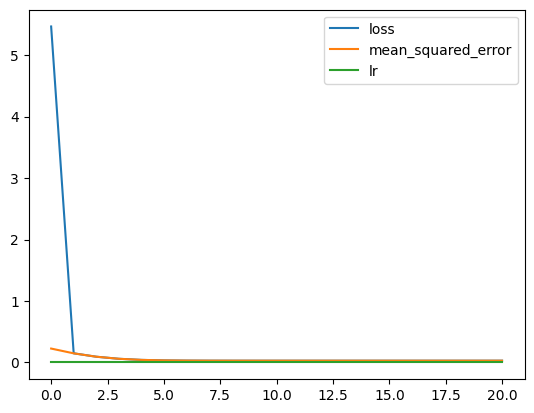

In [118]:
historia=pd.DataFrame(historia.history)
historia[["loss", "mean_squared_error", "lr"]].plot()


In [119]:
# Hacer predicciones
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

8/8 [==============================] - 0s 13ms/step


In [120]:
y_test.shape, testPredict.shape,X_test.shape, y_train.shape, trainPredict.shape, X_train.shape

((254,), (254, 1), (254, 1, 12), (1015,), (1015, 1), (1015, 1, 12))

In [121]:
# Redimensiona X_test a 2 dimensiones para que pueda hacer la transformación inversa
X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[2]))#redimensiono a nuemer de muestras y numero de caracteristicas


In [122]:
X_test_2d.shape

(254, 12)

In [123]:
#TEST_invereti los datos para que tengan sentido y sean reales y compararlos con los datos originales
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(X_test_2d)


In [124]:
# Redimensiona X_train a 2 dimensiones para que pueda hacer la transformación inversa
X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[2]))#redimensiono a numeros de muestras y caracteristicas

In [125]:
#TRAIN_invertimos la escala de los datos para obtener los valores reales y tenga sentido
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(X_train_2d)

In [126]:
# Calcular el error cuadrático medio
trainScore = np.sqrt(mean_squared_error(y_train[:,0], trainPredict[:,0]))#calculamos el RMSE entre las etiquetas verdaderas y 
                                                                        #las que se ha predecido para cuantificar la diferencia
                                                                            # de valores de la serie temporal
print('Train Score: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(y_test[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 9.09 RMSE
Test Score: 9.50 RMSE


In [127]:
# Calcular el meab absolute error percentage y el r2
mape = mean_absolute_percentage_error(y_test[:,0], testPredict[:,0])
print('MAPE: %.2f' % (mape))

r2 = r2_score(y_test[:,0], testPredict[:,0])
print('R2: %.2f' % (r2))


MAPE: 0.41
R2: -0.00


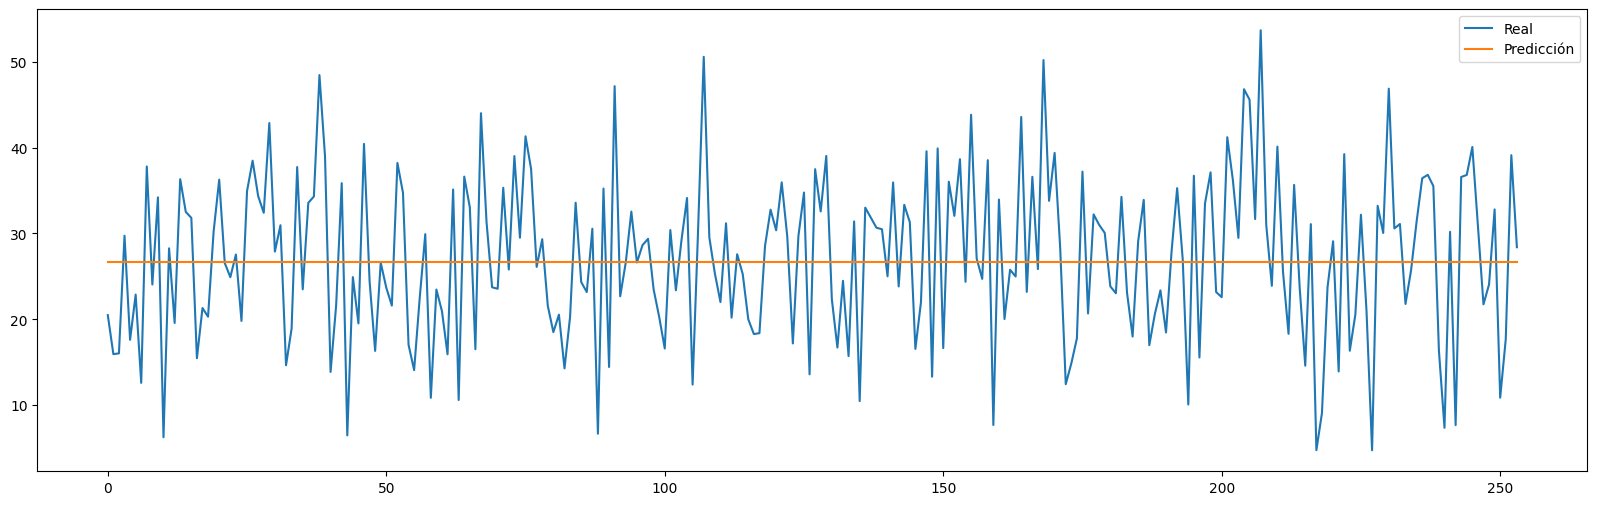

In [128]:
#graficas que podemos hacer con la serie temporal
plt.figure(figsize=(20,6))
plt.plot(y_test[:,0], label='Real')
plt.plot(testPredict[:,0], label='Predicción')
plt.legend()
plt.show()


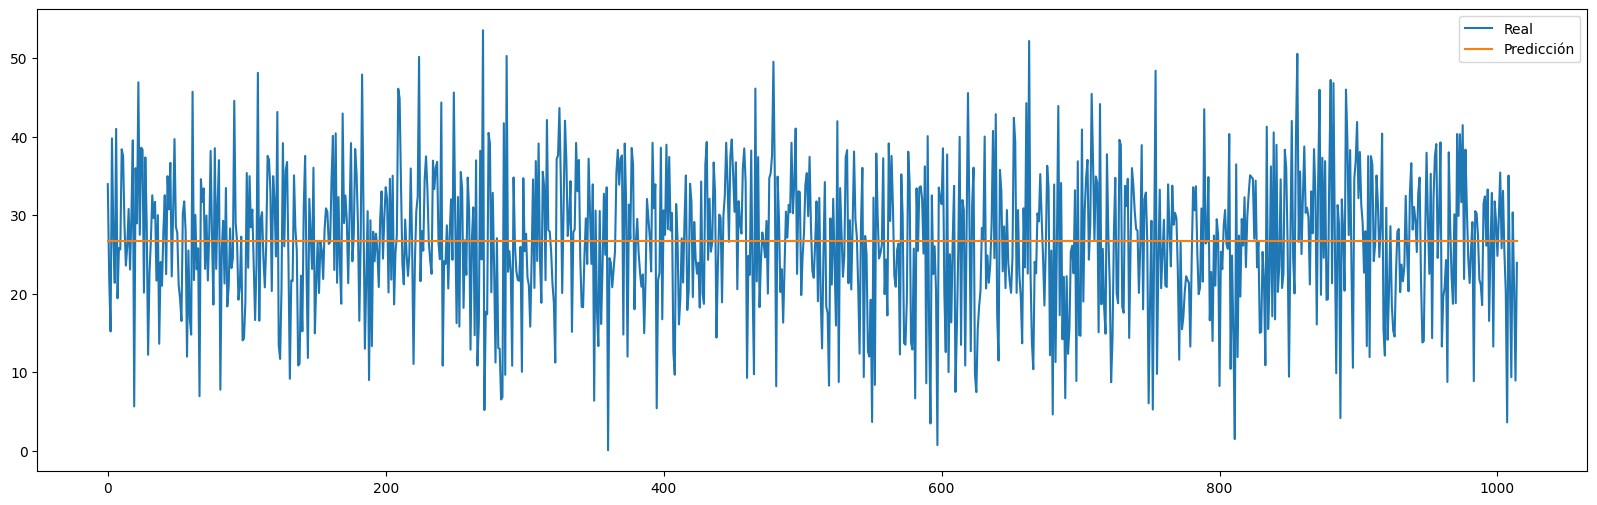

In [129]:
plt.figure(figsize=(20,6))
plt.plot(y_train[:,0], label='Real')
plt.plot(trainPredict[:,0], label='Predicción')
plt.legend()
plt.show()




# segundo modelo

In [130]:
#conmsideramos los valores a cero 
df_dl[df_dl["PAY"]==0]
 # consideramos solo los valores mayores a cero
df_renew=df_dl[df_dl['PAY'] > 0]

In [131]:
#creamos una columna nueva llamada mes que nos indica el mes en el que se encuentra
df_renew['month'] = (df_renew.index // 30) % 12 + 1 
df_renew

C:\Users\victo\AppData\Local\Temp\ipykernel_12600\1927432034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_renew['month'] = (df_renew.index // 30) % 12 + 1


,ID,PAY,ACCEPTED,month
0,786,27.352507,0,1
1,868,51.939040,1,1
2,846,24.451818,1,1
3,249,29.353959,1,1
4,434,20.568923,1,1
...,...,...,...,...
1295,579,25.306900,0,8
1296,871,36.827302,1,8
1297,209,20.824530,0,8
1298,165,26.291693,1,8


In [132]:
# Genera una serie de tiempo con una distribución de Poisson 
# comnezando lambda 1 y aumentando en 1 cada mes
df = pd.DataFrame({'month': range(1, 13), 'PAY': [np.random.poisson(lam=i, size=1)[0] for i in range(1, 13)]})

In [133]:
df.value_counts()

month  PAY
1      3      1
2      0      1
3      4      1
4      5      1
5      6      1
6      5      1
7      3      1
8      11     1
9      9      1
10     4      1
11     5      1
12     13     1
dtype: int64

In [134]:
# Calcula la media de 'ACCEPTED' para cada mes
df['ACCEPTED'] = df_renew.groupby('month')['ACCEPTED'].mean()

In [135]:
# Normaliza los datos
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['PAY', 'ACCEPTED']])

# Divide los datos en conjuntos de entrenamiento y prueba
X = df_scaled[:-1]
y = df_scaled[1:, 0]  # Queremos predecir el 'PAY' del próximo mes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Redimensiona los datos para el modelo LSTM para que tenga la forma [muestras, pasos de tiempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [136]:

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8, 1, 2), (8,), (3, 1, 2), (3,))

In [137]:
model = Sequential()

# Capa Bidireccional con LSTM
model.add(Bidirectional(LSTM(2048, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Capa GRU
model.add(GRU(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())

# Capa SimpleRNN
model.add(SimpleRNN(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Capa LSTM
model.add(Bidirectional(LSTM(1024, return_sequences=True)))
#kernel regularizer es una penalización que se le aplica a los pesos  para evitar el sobreajuste y
# bias regularizer es una penalización que se le aplica a los sesgos para evitar el sobreajuste
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))                  
model.add(Dropout(0.2))     

# Capa Flatten
model.add(Flatten())
model.add(Dense(1024, activation='relu') )
# Capa Dense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(256))
model.add(Dense(64))
model.add(Dense(1))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 1, 4096)          33603584  
 onal)                                                           
                                                                 
 dense_45 (Dense)            (None, 1, 1024)           4195328   
                                                                 
 dropout_39 (Dropout)        (None, 1, 1024)           0         
                                                                 
 gru_10 (GRU)                (None, 1, 1024)           6297600   
                                                                 
 dropout_40 (Dropout)        (None, 1, 1024)           0         
                                                                 
 dense_46 (Dense)            (None, 1, 1024)           1049600   
                                                     

In [138]:
optimizador=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name='Adam',
    clipnorm=1,
    clipvalue=0.2  
    )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=12, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=12, min_lr=0.00001)
list=[early_stopping,reduce_lr]

model.compile(loss='mean_squared_error', optimizer=optimizador, metrics=['mean_squared_error'])
historia=model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=list)

Epoch 1/200
8/8 [==============================] - 8s 47ms/step - loss: 46.3538 - mean_squared_error: 0.3472 - lr: 1.0000e-04
Epoch 2/200
8/8 [==============================] - 0s 44ms/step - loss: 43.8214 - mean_squared_error: 0.3153 - lr: 1.0000e-04
Epoch 3/200
8/8 [==============================] - 0s 43ms/step - loss: 41.3942 - mean_squared_error: 0.2778 - lr: 1.0000e-04
Epoch 4/200
8/8 [==============================] - 0s 45ms/step - loss: 39.0825 - mean_squared_error: 0.2395 - lr: 1.0000e-04
Epoch 5/200
8/8 [==============================] - 0s 45ms/step - loss: 36.8931 - mean_squared_error: 0.2067 - lr: 1.0000e-04
Epoch 6/200
8/8 [==============================] - 0s 44ms/step - loss: 34.8168 - mean_squared_error: 0.1727 - lr: 1.0000e-04
Epoch 7/200
8/8 [==============================] - 0s 42ms/step - loss: 32.8519 - mean_squared_error: 0.1403 - lr: 1.0000e-04
Epoch 8/200
8/8 [==============================] - 0s 43ms/step - loss: 30.9966 - mean_squared_error: 0.1124 - lr: 1.0

<Axes: >

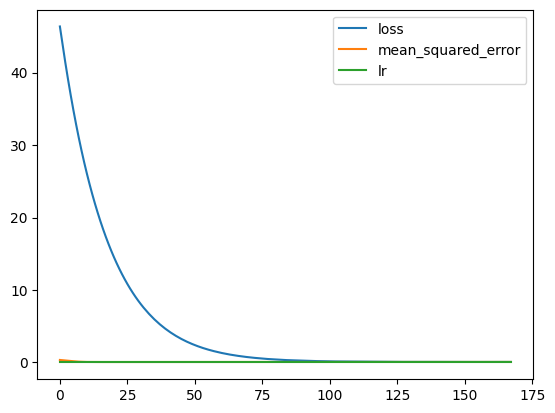

In [139]:
historia=pd.DataFrame(historia.history)
historia[["loss", "mean_squared_error", "lr"]].plot()

In [140]:
train= model.predict(X_train)
test = model.predict(X_test)

1/1 [==============================] - 0s 32ms/step


In [ ]:
df_scaled = scaler.fit_transform(df[['PAY', 'ACCEPTED']])
X = df_scaled[:-1]
y = df_scaled[1:, 0]

In [151]:
X_test.shape, X_train.shape, y_test.shape, y_train.shape , df_scaled.shape

((3, 2), (8, 2), (3,), (8,), (12, 2))

In [148]:
#ahora vamos a invertir los datos para que tengan sentido y sean reales y compararlos con los datos originales
#comenzamos con los datos de entrenamiento
X_test = scaler.inverse_transform(X_test.reshape(X_test.shape[0], X_test.shape[2]))
X_train = scaler.inverse_transform(X_train.reshape(X_train.shape[0], X_train.shape[2]))


In [149]:
X_test.shape, X_train.shape

((3, 2), (8, 2))

In [177]:
train.shape, test.shape, y_train.shape, y_test.shape

((8, 2), (3, 2), (8,), (3,))

In [190]:
# Redimensiona los datos para el modelo LSTM para que tenga la forma [muestras, pasos de tiempo, características]
#X_train = np.array(X_train, dtype=float)
X_test = np.array(X_test, dtype=float)

# Crea un array de unos con la misma longitud que X_train y X_test
#ones_train = np.ones((X_train.shape[0], 1))
ones_test = np.ones((X_test.shape[0], 0))

# Apila horizontalmente X_train y X_test con los arrays de unos
#train = np.hstack((X_train, ones_train))
test = np.hstack((X_test, ones_test))

In [193]:
X_test.shape, test.shape

((3, 2), (3, 2))

In [176]:
"""#ahora con las predicciones
#redimensionamos los datos para que sea lo esperado (x,2)
train=[([x], 1) for x in X_train]
train=np.array(train)
#tetst
test=[([x], 1) for x in X_test]
test=np.array(test)"""


'#ahora con las predicciones\n#redimensionamos los datos para que sea lo esperado (x,2)\ntrain=[([x], 1) for x in X_train]\ntrain=np.array(train)\n#tetst\ntest=[([x], 1) for x in X_test]\ntest=np.array(test)'

In [194]:
#trainPredict = scaler.inverse_transform(train)
testPredict = scaler.inverse_transform(test)

In [195]:
X_test.shape, testPredict.shape, y_test.shape

((3, 2), (3, 2), (3,))

In [200]:
#comprobar los nana en un array
print(np.isnan(testPredict).sum().sum())
print(np.isnan(y_test).sum().sum())
print(np.isnan(X_test).sum().sum())

1
0
1


In [211]:
#calulo la la media de 2 valores sumados y lo dividos en 3
mean_tp= (0.6297619 + 0.63194444)/3
mean_xt= ( 0.57142857 + 0.58888889)/3

# imputo los valores nulos con la media
np.nan_to_num(testPredict, copy=False, nan=mean_tp)
np.nan_to_num(X_test, copy=False, nan=mean_xt)  

#comprobar los nana en un array
print(np.isnan(testPredict).sum())
print(np.isnan(y_test).sum().sum())
print(np.isnan(X_test).sum().sum())

0
0
0


In [213]:
X_test.shape, testPredict.shape, y_test.shape

((3, 2), (3, 2), (3,))

In [214]:
y_test

array([0.23076923, 0.        , 0.38461538])

In [215]:
testPredict

array([[ 0.42056878,  0.6297619 ],
       [39.        ,  0.42056878],
       [52.        ,  0.63194444]])

In [238]:
# Redimensiona y_test y testPredict para que tengan la misma forma
y_test = y_test.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)


In [241]:
# Asegúrate de que y_test y testPredict tengan el mismo número de filas
if len(y_test) != len(testPredict):
    # Si y_test tiene menos filas que testPredict, añade filas de ceros a y_test
    if len(y_test) < len(testPredict):
        zeros = np.zeros((len(testPredict) - len(y_test), 1))
        y_test = np.vstack((y_test, zeros))
    # Si y_test tiene más filas que testPredict, elimina las filas extra de y_test
    else:
        y_test = y_test[:len(testPredict), :]

In [242]:
# Calcular el meab absolute error percentage y el r2
mape = mean_absolute_percentage_error(y_test, testPredict)
print('MAPE: %.2f' % (mape))

r2 = r2_score(y_test, testPredict)
print('R2: %.2f' % (r2))

MAPE: 40293912378049040.00
R2: -30391.16


In [244]:
# Calcular el error cuadrático medio
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 26.45 RMSE
